In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [2]:
plt.style.use('fivethirtyeight')

# Auxiliar functions

In [3]:
def system(t, y, parameters):
    xa, temp = y
    Thx, Uhx, band = parameters 
    
    if (band == 0) or (band==2):
        # only heat exchanger
        k = 0
        Q = Uhx * A * (Thx - temp)
        Qr = 0
    elif band == 1:
        # only reaction - adiabatic mode
        k = 4e6 * np.exp(-7900/temp)
        Q = 0
        Qr = - DHr * MA * Cao * k * (1 - xa) * Vr
    elif band == 3:
        # Reaction + heating
        k = 4e6 * np.exp(-7900/temp)
        Q = Uhx * A * (Thx - temp)
        Qr = - DHr * MA * Cao * k * (1 - xa) * Vr
    elif band == 4:
        # only reaction - isothermal mode
        k = 4e6 * np.exp(-7900/temp)
        Q = 0
        Qr = 0
    
    dxa_dt = k * (1 - xa) 
    dtemp_dt = (Q + Qr)/(Vr * rhoCp)
    
   
    return [dxa_dt, dtemp_dt]

def event(t, y, band):
    if band == 0:
        r = y[1] - Tfcal
    elif band == 1:
        r = y[0] - XAmax 
        if y[0] >= XAmax:
            r = y[0] - XAmax 
        elif y[1] >= TmaxR:
            r = y[1] - TmaxR 
    elif band == 2:
        r = y[1] - Tfenf  
    elif band == 3:
        r = y[1] - TmaxR            
    elif band == 4:
        r = y[0] - XAmax
    return r
    

# Data

In [4]:
# Datos del sobre el intercambiador de calor
Uc = 1180      # Coeficiente global para el enfriamiento, W/m^2 oC
Us = 1360      # Coeficiente global para el calentamiento, W/m^2 oC
A = 3.3         # Area de transferencia de calor, m^2
Ts = 120 + 273.15       # Temperatura del vapor, oC
Tc = 15 + 273.15        # Temperatura del agua de enfriamiento, oC
#
# Datos del fluido reaccionante
rhoCp = 4.2e6                 # Propiedad del fluido reaccionante J/m^3/C
MA = 100                     # Peso molecular de A, kg/kmol
Cao = 1                      # Concentracion inicial de A, kmol/m^3
DHr = -1.67e6                 # Calor de reaccion, J/kg
#
#Datos del reactor
Vr = 5             # Volumen del reactor, m^3
Tini = 20 + 273.15          # Temperatura inicial de fluido reaccionante, oC
Tfcal = 55 + 273.15         # Temperatura final del calentamiento del fluido, oC
TmaxR = 95 + 273.15         # Temperatura maxima de reaccion, oC
XAmax = 0.9         # Conversion maxima permitida de A, adim
Tfenf = 45 + 273.15         # Temperatura final de la mezcla reaccionante, oC

# Solution

## Case I. First policy of operation

### Step 1. Heating Up

In [5]:
tSpan = [0, 1e5]

ic = [0, Tini] 
bandera = 0 
p = [Ts, Us, bandera] 

fun_ode = lambda t, y: system(t, y, p)
fun_events = lambda t, y: event(t, y, bandera)
fun_events.terminal = True
fun_events.direction = 0

solution01 = solve_ivp(fun_ode, tSpan, ic, events=fun_events)

In [6]:
print('The required heating time to reach {:.0f} oC is {:.2f} s'.format(Tfcal - 273.15, solution01.t_events[0][0]))

The required heating time to reach 55 oC is 2006.88 s


### Step 2. Reaction under adiabatic restriction

Stop Criteria: final conversion 90% or Reaction temperature 95 C

In [7]:
ic = [0, Tfcal]
bandera = 1

p[-1] = bandera

fun_ode = lambda t, y: system(t, y, p)
fun_events = lambda t, y: event(t, y, bandera)
fun_events.terminal = True
fun_events.direction = 0

solution02 = solve_ivp(fun_ode, tSpan, ic, events=fun_events)

In [8]:
print(('The required reaction time to reach {:.2f} oC and {:.2f}% of conversion is {:.2f} s'.format(
      solution02.y_events[0][0][1]-273.15, solution02.y_events[0][0][0]*100, solution02.t_events[0][0])))

The required reaction time to reach 90.79 oC and 90.00% of conversion is 4063.99 s


### Step 3. Cooling until T = 45C

In [9]:
ic = solution02.y_events[0][0]
bandera = 2
p = [Tc, Uc, bandera]

fun_ode = lambda t, y: system(t, y, p)
fun_events = lambda t, y: event(t, y, bandera)
fun_events.terminal = True
fun_events.direction = 0

solution03 = solve_ivp(fun_ode, tSpan, ic, events=fun_events)

In [10]:
print(('The required cooling time to reach {:.0f} oC is {:.2f} s'.format(
    solution03.y_events[0][0][1]-273.15, solution03.t_events[0][0])))

The required cooling time to reach 45 oC is 4954.70 s


In [11]:
summary_y_part1 = np.hstack((solution01.y, solution02.y, solution03.y))

In [12]:
summary_time_part1 = np.hstack((solution01.t, 
                                solution02.t + solution01.t[-1], 
                                solution03.t + solution01.t[-1] + + solution02.t[-1]))

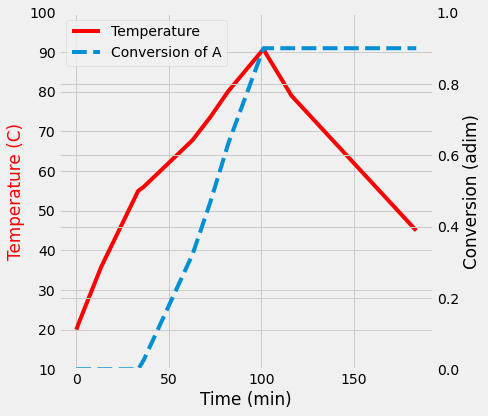

In [13]:
fig, ax1 = plt.subplots(figsize=(7,6))
ax2 = ax1.twinx()
line1 = ax1.plot(summary_time_part1/60, summary_y_part1[1]-273.15,
                 color='red', label='Temperature')
ax1.set_xlabel('Time (min)') 
ax1.set_ylabel('Temperature (C)', color='red')

line2 = ax2.plot(summary_time_part1/60, summary_y_part1[0],
                 ls='--', label='Conversion of A')
ax2.set_ylabel('Conversion (adim)') 
ax2.set_ylim(0, 1)
ax1.set_ylim(10, 100)

lns = line1 + line2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs)

plt.tight_layout()
#fig.savefig('../figures/003_02_03.png')
plt.show()

## Case II. Second policy of operation

### Step 1. Heating Up plus reaction until T = 95C

In [14]:
ic = [0, Tini] 
bandera = 3 
p = [Ts, Us, bandera] 

fun_ode = lambda t, y: system(t, y, p)
fun_events = lambda t, y: event(t, y, bandera)
fun_events.terminal = True
fun_events.direction = 0

solution04 = solve_ivp(fun_ode, tSpan, ic, events=fun_events)

In [15]:
print(('The required reaction time to reach {:.2f} oC and {:.2f}% of conversion is {:.2f} s'.format(
      solution04.y_events[0][0][1]-273.15, solution04.y_events[0][0][0]*100, solution04.t_events[0][0])))

The required reaction time to reach 95.00 oC and 67.85% of conversion is 3442.23 s


### Step 2. Isothermal Reaction until 90% conversion

In [16]:
ic = solution04.y_events[0][0] 
bandera = 4
p[-1] = bandera 

fun_ode = lambda t, y: system(t, y, p)
fun_events = lambda t, y: event(t, y, bandera)
fun_events.terminal = True
fun_events.direction = 0

solution05 = solve_ivp(fun_ode, tSpan, ic, events=fun_events)

In [17]:
print(('The required reaction time to reach at {:.2f} oC a {:.2f}% of conversion is {:.2f} s'.format(
      solution05.y_events[0][0][1]-273.15, solution05.y_events[0][0][0]*100, solution05.t_events[0][0])))

The required reaction time to reach at 95.00 oC a 90.00% of conversion is 608.66 s


In [18]:
ic = solution05.y_events[0][0]
bandera = 2
p = [Tc, Uc, bandera]

fun_ode = lambda t, y: system(t, y, p)
fun_events = lambda t, y: event(t, y, bandera)
fun_events.terminal = True
fun_events.direction = 0

solution06 = solve_ivp(fun_ode, tSpan, ic, events=fun_events)

In [19]:
print(('The required cooling time to reach {:.0f} oC is {:.2f} s'.format(
    solution06.y_events[0][0][1]-273.15, solution06.t_events[0][0])))

The required cooling time to reach 45 oC is 5253.71 s


In [20]:
summary_y_part2 = np.hstack((solution04.y, solution05.y, solution06.y))
summary_time_part2 = np.hstack((solution04.t, 
                                solution05.t + solution04.t[-1], 
                                solution06.t + solution04.t[-1] + + solution05.t[-1]))

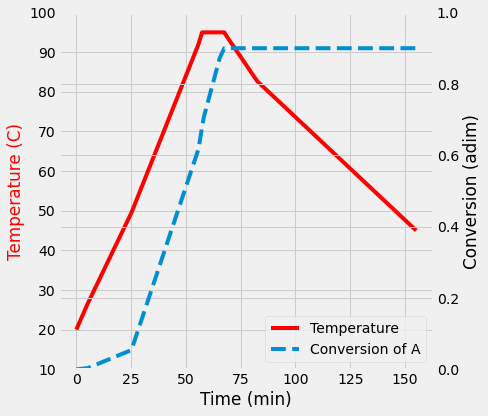

In [21]:
fig, ax1 = plt.subplots(figsize=(7,6))
ax2 = ax1.twinx()
line1 = ax1.plot(summary_time_part2/60, summary_y_part2[1]-273.15,
                 color='red', label='Temperature')
ax1.set_xlabel('Time (min)') 
ax1.set_ylabel('Temperature (C)', color='red')

line2 = ax2.plot(summary_time_part2/60, summary_y_part2[0],
                 ls='--', label='Conversion of A')
ax2.set_ylabel('Conversion (adim)') 
ax2.set_ylim(0, 1)
ax1.set_ylim(10, 100)

lns = line1 + line2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=4)

plt.tight_layout()
plt.show()